# Trainers

In this notebook I test trainer implementations on various environments.

## Monitoring setup
This sets up the logging system to be able to monitor the training progress of the agent

In [1]:
import logging
from amarl.messenger import training_monitor

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s:%(name)s: %(message)s')
logging.root.setLevel(logging.INFO)

logger = logging.getLogger(__name__)

/home/bernhard/miniconda3/envs/AMARL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bernhard/miniconda3/envs/AMARL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bernhard/miniconda3/envs/AMARL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bernhard/miniconda3/envs/AMARL/lib

## A2C Agent
This section trains and analyses the A2C implementation. With it I can validate the basic A2C algorithm and see if it 
works on a variety of environments.

### Train the Agent
In the part I actually train the agent on one of the testing environments. It is a good idea to look at the gym unit
testing environment first and try to solve that. If this doesn't work, there is something wrong either with the
algorithm or the setup. Also make sure to sanity check input signal. Here the problem was that the input image was
actually completely mangled by the torch vision pipeline because I used it wrong initially.

In [8]:
import amarl
import gym
from amarl.trainers import A2CTrainer
from amarl.wrappers import MultipleEnvs, active_gym, OriginalReturnWrapper, SignReward,  TorchObservation, StackFrames

def make_env():
    e = gym.make('CubeCrash-v0')
    e = OriginalReturnWrapper(e)
    e = SignReward(e)
    e = TorchObservation(e)
#     e = StackFrames(e, size=4)
    return e

env = MultipleEnvs(make_env, num_envs=16)
with active_gym(env) as env, training_monitor(logger, performance_sample_size=10000) as monitor:
    com = A2CTrainer(env, config={'rollout_horizon': 5, 'device': 'cuda'})
    try:
        amarl.run(com, num_steps=int(1e5))
    finally:
        pass

/home/bernhard/miniconda3/envs/AMARL/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

2020-04-13 11:06:54,449 - INFO:__main__: steps:    2960, average reward:	-0.76
2020-04-13 11:06:55,865 - INFO:__main__: steps:    6112, average reward:	-0.66
2020-04-13 11:06:57,105 - INFO:__main__: steps:    8960, average reward:	-0.60
2020-04-13 11:06:57,561 - INFO:__main__: steps:   10000, performance:	2241.08 steps/s
2020-04-13 11:06:58,377 - INFO:__main__: steps:   11887, average reward:	-0.64
2020-04-13 11:06:59,553 - INFO:__main__: steps:   14608, average reward:	-0.58
2020-04-13 11:07:00,817 - INFO:__main__: steps:   17504, average reward:	-0.64
2020-04-13 11:07:01,913 - INFO:__main__: steps:   20000, performance:	2298.10 steps/s
2020-04-13 11:07:02,085 - INFO:__main__: steps:   20383, average reward:	-0.74
2020-04-13 11:07:03,379 - INFO:__main__: steps:   23341, average reward:	-0.68
2020-04-13 11:07:04,618 - INFO:__main__: steps:   26192, average reward:	-0.58
2020-04-13 11:07:05,774 - INFO:__main__: steps:   28784, average reward:	-0.78
2020-04-13 11:07:06,326 - INFO:__main_

2020-04-13 11:08:36,250 - INFO:__main__: steps:  232720, average reward:	-0.84
2020-04-13 11:08:37,602 - INFO:__main__: steps:  235680, average reward:	-0.54
2020-04-13 11:08:38,905 - INFO:__main__: steps:  238576, average reward:	-0.52
2020-04-13 11:08:39,526 - INFO:__main__: steps:  240000, performance:	2212.44 steps/s
2020-04-13 11:08:40,265 - INFO:__main__: steps:  241536, average reward:	-0.62
2020-04-13 11:08:41,628 - INFO:__main__: steps:  244383, average reward:	-0.60
2020-04-13 11:08:43,031 - INFO:__main__: steps:  247391, average reward:	-0.72
2020-04-13 11:08:44,204 - INFO:__main__: steps:  250000, performance:	2137.83 steps/s
2020-04-13 11:08:44,303 - INFO:__main__: steps:  250207, average reward:	-0.66
2020-04-13 11:08:45,646 - INFO:__main__: steps:  253088, average reward:	-0.62
2020-04-13 11:08:46,917 - INFO:__main__: steps:  256000, average reward:	-0.72
2020-04-13 11:08:48,265 - INFO:__main__: steps:  258896, average reward:	-0.76
2020-04-13 11:08:48,761 - INFO:__main_

### Plot Results
It is easier to understand how the agent is performing by plotting the metrics of the training. Sum bugs can be subtle,
for instance it was not that obvious that the frame stack ordering was wrong, because the agent still learned a good
policy and performed reasonably well. Because of such subtle bugs the algorithm can become more sensitive to certain
hyper-parameters (i.e. gradient clipping), resulting in a misleading perception of importance of these parameters. Be
careful!

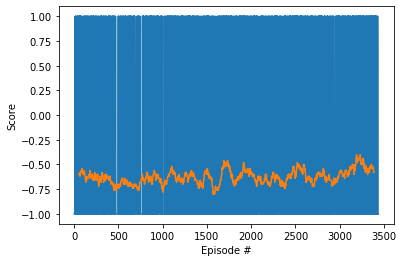

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(a, n=3):
    ret = np.cumsum(np.insert(a, 0, 0))
    return (ret[n:] - ret[:-n]) / n

scores = monitor.captured_returns
avg_window = 100
scores_avg = moving_average(scores, avg_window)
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores)
start = avg_window // 2
ax.plot(range(start, start + len(scores_avg)), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


## A2C LSTM Agent
In this section I train and analyse an A2C agent making use of a LSTM cell to keep track of motion. The important bit 
here is that it solve environments without needing a stack of frames to figure out motion, but actually learn it on a 
frame by frame basis. This section makes sure it works on simple environments, before moving on to the more challenging
partially observable environments needed in multi agent setups that require inter agent communication.

### Train the Agent

In [7]:
import amarl
import gym
from amarl.trainers import A2CLSTMTrainer
from amarl.wrappers import MultipleEnvs, active_gym, OriginalReturnWrapper, SignReward,  TorchObservation, StackFrames

def make_env():
    e = gym.make('CubeCrashSparse-v0')
    e = OriginalReturnWrapper(e)
    e = SignReward(e)
    e = TorchObservation(e)
    return e

env = MultipleEnvs(make_env, num_envs=16)
with active_gym(env) as env, training_monitor(logger, performance_sample_size=10000) as monitor:
    com = A2CLSTMTrainer(env, config={'rollout_horizon': 5, 'device': 'cuda', 
                                      'optimizer': {'RMSprop': {'lr':5e-4, 'alpha': 0.99, 'eps': 1e-5}}})
    try:
        amarl.run(com, num_steps=int(3e5))
    finally:
        pass

/home/bernhard/miniconda3/envs/AMARL/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.

2020-04-13 10:54:26,664 - INFO:__main__: steps:    3072, average reward:	-0.76
2020-04-13 10:54:29,830 - INFO:__main__: steps:    5888, average reward:	-0.64
2020-04-13 10:54:32,922 - INFO:__main__: steps:    8640, average reward:	-0.72
2020-04-13 10:54:34,480 - INFO:__main__: steps:   10000, performance:	883.39 steps/s
2020-04-13 10:54:36,263 - INFO:__main__: steps:   11568, average reward:	-0.66
2020-04-13 10:54:39,484 - INFO:__main__: steps:   14416, average reward:	-0.72
2020-04-13 10:54:42,915 - INFO:__main__: steps:   17296, average reward:	-0.70
2020-04-13 10:54:45,996 - INFO:__main__: steps:   20000, performance:	868.37 steps/s
2020-04-13 10:54:46,168 - INFO:__main__: steps:   20144, average reward:	-0.58
2020-04-13 10:54:49,452 - INFO:__main__: steps:   22928, average reward:	-0.62
2020-04-13 10:54:52,684 - INFO:__main__: steps:   25760, average reward:	-0.64
2020-04-13 10:54:55,897 - INFO:__main__: steps:   28624, average reward:	-0.56
2020-04-13 10:54:57,508 - INFO:__main__:

2020-04-13 10:58:43,689 - INFO:__main__: steps:  231759, average reward:	-0.72
2020-04-13 10:58:46,868 - INFO:__main__: steps:  234575, average reward:	-0.78
2020-04-13 10:58:50,028 - INFO:__main__: steps:  237391, average reward:	-0.76
2020-04-13 10:58:52,941 - INFO:__main__: steps:  240000, performance:	890.88 steps/s
2020-04-13 10:58:53,277 - INFO:__main__: steps:  240272, average reward:	-0.70
2020-04-13 10:58:56,488 - INFO:__main__: steps:  243136, average reward:	-0.70
2020-04-13 10:58:59,815 - INFO:__main__: steps:  246096, average reward:	-0.68
2020-04-13 10:59:03,049 - INFO:__main__: steps:  249008, average reward:	-0.72
2020-04-13 10:59:04,153 - INFO:__main__: steps:  250000, performance:	891.92 steps/s
2020-04-13 10:59:06,356 - INFO:__main__: steps:  251967, average reward:	-0.58
2020-04-13 10:59:09,396 - INFO:__main__: steps:  254703, average reward:	-0.60
2020-04-13 10:59:12,699 - INFO:__main__: steps:  257664, average reward:	-0.56
2020-04-13 10:59:15,309 - INFO:__main__:

### Plot Results

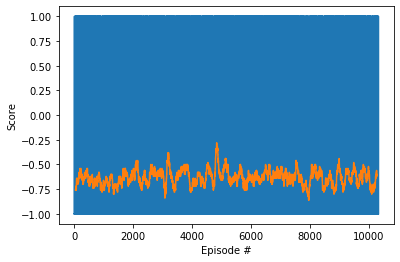

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(a, n=3):
    ret = np.cumsum(np.insert(a, 0, 0))
    return (ret[n:] - ret[:-n]) / n

scores = monitor.captured_returns
avg_window = 100
scores_avg = moving_average(scores, avg_window)
fig, ax = plt.subplots()
ax.plot(range(len(scores)), scores)
start = avg_window // 2
ax.plot(range(start, start + len(scores_avg)), scores_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()